# Neural Network v3 - Ensemble-Architektur mit Parallelen Experten
## Komplexität reduzieren durch intelligente Architektur

**Neue Strategie:**
- Statt eines großen tiefen Netzwerks: **Mehrere kleine parallele "Expert"-Netzwerke**
- Jeder Expert verarbeitet den Input unabhängig
- Die Outputs werden kombiniert für die finale Prediction
- **Vorteil**: Mehr Parameter ohne starkes Overfitting!

**Architektur:**
```
Input (15 Features)
    ↓
    ├─→ Expert 1 → Feature(s)
    ├─→ Expert 2 → Feature(s)
    ├─→ Expert 3 → Feature(s)
    ├─→ Expert 4 → Feature(s)
    ├─→ Expert 5 → Feature(s)
    ├─→ Expert 6 → Feature(s)
    ├─→ Expert 7 → Feature(s)
    └─→ Expert 8 → Feature(s)
         ↓
    Concatenate all features
         ↓
    Linear Layer → 1 Output
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch Version: {torch.__version__}")

Using device: cpu
PyTorch Version: 2.9.1


## 1. Daten laden (wie vorher)

In [2]:
BASE_DIR = Path.cwd().parent
DATA_PATH = BASE_DIR / "housing.csv"

df_full = pd.read_csv(DATA_PATH)
df_full['price_quartile'] = pd.qcut(df_full['median_house_value'], q=4, labels=False)
df_small = df_full.groupby('price_quartile', group_keys=False).apply(
    lambda x: x.sample(n=25, random_state=42)
).drop('price_quartile', axis=1).reset_index(drop=True)

print(f"Datensatz: {len(df_small)} Zeilen")

# Feature Engineering
def engineer_features(df):
    df = df.copy()
    df['households'] = df['households'].replace(0, np.nan)
    df['total_rooms'] = df['total_rooms'].replace(0, np.nan)
    df['rooms_per_household'] = df['total_rooms'] / df['households']
    df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
    df['population_per_household'] = df['population'] / df['households']
    return df

df_small = engineer_features(df_small)
df_small = pd.get_dummies(df_small, columns=['ocean_proximity'], drop_first=False)

X = df_small.drop('median_house_value', axis=1)
y = df_small['median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(imputer.fit_transform(X_train))
X_test_scaled = scaler.transform(imputer.transform(X_test))
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

print(f"Training: {len(X_train)} | Test: {len(X_test)}")
print(f"Features: {X_train_tensor.shape[1]}")

Datensatz: 100 Zeilen
Training: 80 | Test: 20
Features: 15


## 2. Ensemble-Architektur: Parallel Expert Networks

Jeder "Expert" ist ein kleines unabhängiges Netzwerk, das Features extrahiert.

In [3]:
class ExpertLayer(nn.Module):
    """Ein einzelner Expert: Input -> Hidden -> Output Features"""
    def __init__(self, input_dim, hidden_dim, output_features, dropout_rate=0.3):
        super(ExpertLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, output_features)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Keine Aktivierung, lineare Features
        return x

class ParallelExpertNet(nn.Module):
    """Ensemble von parallelen Experten"""
    def __init__(self, input_dim, num_experts=8, expert_hidden=16, expert_output=3, dropout_rate=0.3):
        super(ParallelExpertNet, self).__init__()
        
        self.num_experts = num_experts
        self.expert_output = expert_output
        
        # Erstelle Experten
        self.experts = nn.ModuleList([
            ExpertLayer(input_dim, expert_hidden, expert_output, dropout_rate)
            for _ in range(num_experts)
        ])
        
        # Finales Layer: Kombiniert alle Expert-Outputs
        combined_features = num_experts * expert_output
        self.final_layer = nn.Linear(combined_features, 1)
        
    def forward(self, x):
        # Jeder Expert verarbeitet den Input parallel
        expert_outputs = [expert(x) for expert in self.experts]
        
        # Concatenate alle Expert-Outputs
        combined = torch.cat(expert_outputs, dim=1)
        
        # Finale Prediction
        output = self.final_layer(combined)
        return output

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Teste verschiedene Konfigurationen
input_dim = X_train_tensor.shape[1]

print("\n" + "="*70)
print("ENSEMBLE ARCHITEKTUREN")
print("="*70)

configs = [
    ("Small Ensemble", 8, 12, 1, 0.2),   # 8 Experten, Hidden=12, Output=1
    ("Medium Ensemble", 8, 16, 3, 0.3),  # 8 Experten, Hidden=16, Output=3
    ("Large Ensemble", 12, 16, 3, 0.3),  # 12 Experten, Hidden=16, Output=3
]

for name, num_exp, hidden, out_feat, dropout in configs:
    model = ParallelExpertNet(input_dim, num_exp, hidden, out_feat, dropout)
    params = count_parameters(model)
    print(f"\n{name}:")
    print(f"  • {num_exp} Experten")
    print(f"  • Expert: {input_dim} → {hidden} → {out_feat}")
    print(f"  • Combined Features: {num_exp * out_feat}")
    print(f"  • Dropout: {dropout*100:.0f}%")
    print(f"  • Total Parameters: {params:,}")


ENSEMBLE ARCHITEKTUREN

Small Ensemble:
  • 8 Experten
  • Expert: 15 → 12 → 1
  • Combined Features: 8
  • Dropout: 20%
  • Total Parameters: 1,649

Medium Ensemble:
  • 8 Experten
  • Expert: 15 → 16 → 3
  • Combined Features: 24
  • Dropout: 30%
  • Total Parameters: 2,481

Large Ensemble:
  • 12 Experten
  • Expert: 15 → 16 → 3
  • Combined Features: 36
  • Dropout: 30%
  • Total Parameters: 3,721


## 3. Early Stopping (wie v2)

In [4]:
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_epoch = 0
        
    def __call__(self, val_loss, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_epoch = epoch
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose and self.counter % 5 == 0:
                print(f"    Early Stopping Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"\n    ⚠️  Early Stopping bei Epoch {epoch}!")
                    print(f"    Bester Val Loss: {self.best_loss:.4f} (Epoch {self.best_epoch})")
        else:
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.counter = 0

def train_ensemble_model(
    model, X_train, y_train, X_test, y_test,
    max_epochs=500, batch_size=16, lr=0.001, weight_decay=0.01, patience=20
):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    history = {'train_loss': [], 'val_loss': [], 'lr': []}
    
    for epoch in range(max_epochs):
        model.train()
        train_losses = []
        
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        avg_train_loss = np.mean(train_losses)
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test).squeeze()
            val_loss = criterion(val_outputs, y_test).item()
        
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['lr'].append(current_lr)
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{max_epochs}] - Train: {avg_train_loss:.4f}, Val: {val_loss:.4f}, LR: {current_lr:.6f}")
        
        early_stopping(val_loss, epoch + 1)
        if early_stopping.early_stop:
            break
    
    final_epoch = epoch + 1
    print(f"\n✓ Training beendet nach {final_epoch} Epochen")
    return history, final_epoch

print("Training-Funktion bereit!")

Training-Funktion bereit!


## 4. Trainiere Ensemble-Modelle

In [5]:
MAX_EPOCHS = 500
BATCH_SIZE = 16
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.01
PATIENCE = 20

# Small Ensemble
print("="*70)
print("TRAINING: Small Ensemble (8 Experts, Hidden=12, Output=1)")
print("="*70)
model_small_ens = ParallelExpertNet(input_dim, num_experts=8, expert_hidden=12, 
                                     expert_output=1, dropout_rate=0.2).to(device)
history_small_ens, epochs_small = train_ensemble_model(
    model_small_ens, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
    MAX_EPOCHS, BATCH_SIZE, LEARNING_RATE, WEIGHT_DECAY, PATIENCE
)

# Medium Ensemble
print("\n" + "="*70)
print("TRAINING: Medium Ensemble (8 Experts, Hidden=16, Output=3)")
print("="*70)
model_medium_ens = ParallelExpertNet(input_dim, num_experts=8, expert_hidden=16,
                                      expert_output=3, dropout_rate=0.3).to(device)
history_medium_ens, epochs_medium = train_ensemble_model(
    model_medium_ens, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
    MAX_EPOCHS, BATCH_SIZE, LEARNING_RATE, WEIGHT_DECAY, PATIENCE
)

# Large Ensemble
print("\n" + "="*70)
print("TRAINING: Large Ensemble (12 Experts, Hidden=16, Output=3)")
print("="*70)
model_large_ens = ParallelExpertNet(input_dim, num_experts=12, expert_hidden=16,
                                     expert_output=3, dropout_rate=0.3).to(device)
history_large_ens, epochs_large = train_ensemble_model(
    model_large_ens, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
    MAX_EPOCHS, BATCH_SIZE, LEARNING_RATE, WEIGHT_DECAY, PATIENCE
)

print("\n" + "="*70)
print("ALLE ENSEMBLE-MODELLE TRAINIERT!")
print("="*70)
print(f"Small Ensemble:  {epochs_small} Epochen")
print(f"Medium Ensemble: {epochs_medium} Epochen")
print(f"Large Ensemble:  {epochs_large} Epochen")

TRAINING: Small Ensemble (8 Experts, Hidden=12, Output=1)
Epoch [50/500] - Train: 0.2746, Val: 0.3702, LR: 0.001000
    Early Stopping Counter: 5/20
Epoch [100/500] - Train: 0.2156, Val: 0.3181, LR: 0.001000
    Early Stopping Counter: 5/20
    Early Stopping Counter: 10/20
    Early Stopping Counter: 15/20
    Early Stopping Counter: 20/20

    ⚠️  Early Stopping bei Epoch 115!
    Bester Val Loss: 0.3115 (Epoch 95)

✓ Training beendet nach 115 Epochen

TRAINING: Medium Ensemble (8 Experts, Hidden=16, Output=3)
Epoch [50/500] - Train: 0.3153, Val: 0.3585, LR: 0.001000
    Early Stopping Counter: 5/20
    Early Stopping Counter: 5/20
Epoch [100/500] - Train: 0.2056, Val: 0.2931, LR: 0.001000
    Early Stopping Counter: 5/20
    Early Stopping Counter: 5/20
    Early Stopping Counter: 10/20
    Early Stopping Counter: 15/20
    Early Stopping Counter: 20/20

    ⚠️  Early Stopping bei Epoch 127!
    Bester Val Loss: 0.2892 (Epoch 107)

✓ Training beendet nach 127 Epochen

TRAINING: Larg

## 5. Loss Curves - Ensemble Models

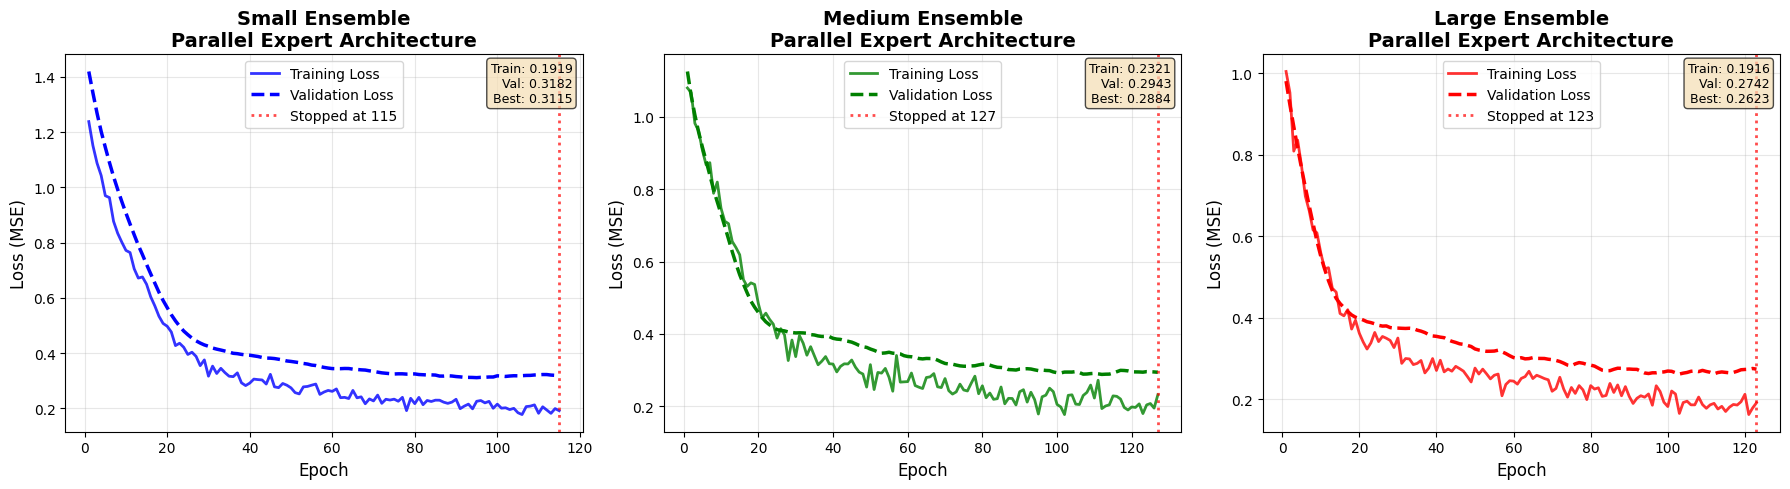

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

histories = [
    (history_small_ens, epochs_small, 'Small Ensemble', 'blue'),
    (history_medium_ens, epochs_medium, 'Medium Ensemble', 'green'),
    (history_large_ens, epochs_large, 'Large Ensemble', 'red')
]

for idx, (history, final_epoch, title, color) in enumerate(histories):
    ax = axes[idx]
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    ax.plot(epochs_range, history['train_loss'], label='Training Loss', 
            color=color, alpha=0.8, linewidth=2)
    ax.plot(epochs_range, history['val_loss'], label='Validation Loss',
            color=color, linestyle='--', linewidth=2.5)
    ax.axvline(x=final_epoch, color='red', linestyle=':', linewidth=2, alpha=0.7,
               label=f'Stopped at {final_epoch}')
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss (MSE)', fontsize=12)
    ax.set_title(f'{title}\nParallel Expert Architecture', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    final_train = history['train_loss'][-1]
    final_val = history['val_loss'][-1]
    best_val = min(history['val_loss'])
    
    ax.text(0.98, 0.98,
            f'Train: {final_train:.4f}\nVal: {final_val:.4f}\nBest: {best_val:.4f}',
            transform=ax.transAxes, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), fontsize=9)

plt.tight_layout()
plt.show()

## 6. Performance-Analyse

In [7]:
models_ens = {
    'Small Ensemble': model_small_ens,
    'Medium Ensemble': model_medium_ens,
    'Large Ensemble': model_large_ens
}

results_ens = []

for name, model in models_ens.items():
    model.eval()
    with torch.no_grad():
        y_train_pred_scaled = model(X_train_tensor).squeeze().cpu().numpy()
        y_test_pred_scaled = model(X_test_tensor).squeeze().cpu().numpy()
    
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    rmse_gap = test_rmse - train_rmse
    rmse_gap_percent = (rmse_gap / train_rmse) * 100
    
    params = count_parameters(model)
    
    results_ens.append({
        'Model': name,
        'Parameters': params,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'RMSE Gap': rmse_gap,
        'Gap %': rmse_gap_percent,
        'Train R²': train_r2,
        'Test R²': test_r2
    })

results_ens_df = pd.DataFrame(results_ens)

print("\n" + "="*100)
print("PERFORMANCE: Ensemble-Modelle (Parallel Experts)")
print("="*100)
print(results_ens_df.to_string(index=False))
print("="*100)


PERFORMANCE: Ensemble-Modelle (Parallel Experts)
          Model  Parameters   Train RMSE    Test RMSE     RMSE Gap     Gap %  Train R²  Test R²
 Small Ensemble        1649 46706.892720 63577.508252 16870.615531 36.120184  0.828278 0.698317
Medium Ensemble        2481 45705.164097 61142.265423 15437.101326 33.775399  0.835565 0.720985
 Large Ensemble        3721 44456.994679 59020.459286 14563.464607 32.758545  0.844423 0.740014


## 7. Overfitting-Analyse

In [8]:
def analyze_overfitting_v3(train_rmse, test_rmse, model_name, params):
    gap = test_rmse - train_rmse
    gap_percent = (gap / train_rmse) * 100
    
    print(f"\n{'='*70}")
    print(f"ANALYSE: {model_name}")
    print(f"{'='*70}")
    print(f"Parameter:        {params:>10,}")
    print(f"Training RMSE:    ${train_rmse:>10,.2f}")
    print(f"Test RMSE:        ${test_rmse:>10,.2f}")
    print(f"Gap:              ${gap:>10,.2f} ({gap_percent:>6.1f}%)")
    print(f"{'-'*70}")
    
    if gap_percent > 30:
        verdict = "🔴 STARKES OVERFITTING"
    elif gap_percent > 15:
        verdict = "🟡 MODERATES OVERFITTING"
    elif gap_percent > -5:
        verdict = "🟢 GUTER FIT"
    else:
        verdict = "🔵 UNDERFITTING"
    
    print(f"BEWERTUNG: {verdict}")
    print(f"{'='*70}")

for _, row in results_ens_df.iterrows():
    analyze_overfitting_v3(row['Train RMSE'], row['Test RMSE'], 
                           row['Model'], row['Parameters'])


ANALYSE: Small Ensemble
Parameter:             1,649
Training RMSE:    $ 46,706.89
Test RMSE:        $ 63,577.51
Gap:              $ 16,870.62 (  36.1%)
----------------------------------------------------------------------
BEWERTUNG: 🔴 STARKES OVERFITTING

ANALYSE: Medium Ensemble
Parameter:             2,481
Training RMSE:    $ 45,705.16
Test RMSE:        $ 61,142.27
Gap:              $ 15,437.10 (  33.8%)
----------------------------------------------------------------------
BEWERTUNG: 🔴 STARKES OVERFITTING

ANALYSE: Large Ensemble
Parameter:             3,721
Training RMSE:    $ 44,456.99
Test RMSE:        $ 59,020.46
Gap:              $ 14,563.46 (  32.8%)
----------------------------------------------------------------------
BEWERTUNG: 🔴 STARKES OVERFITTING


## 8. Vergleich: Ensemble vs. Standard Architecture

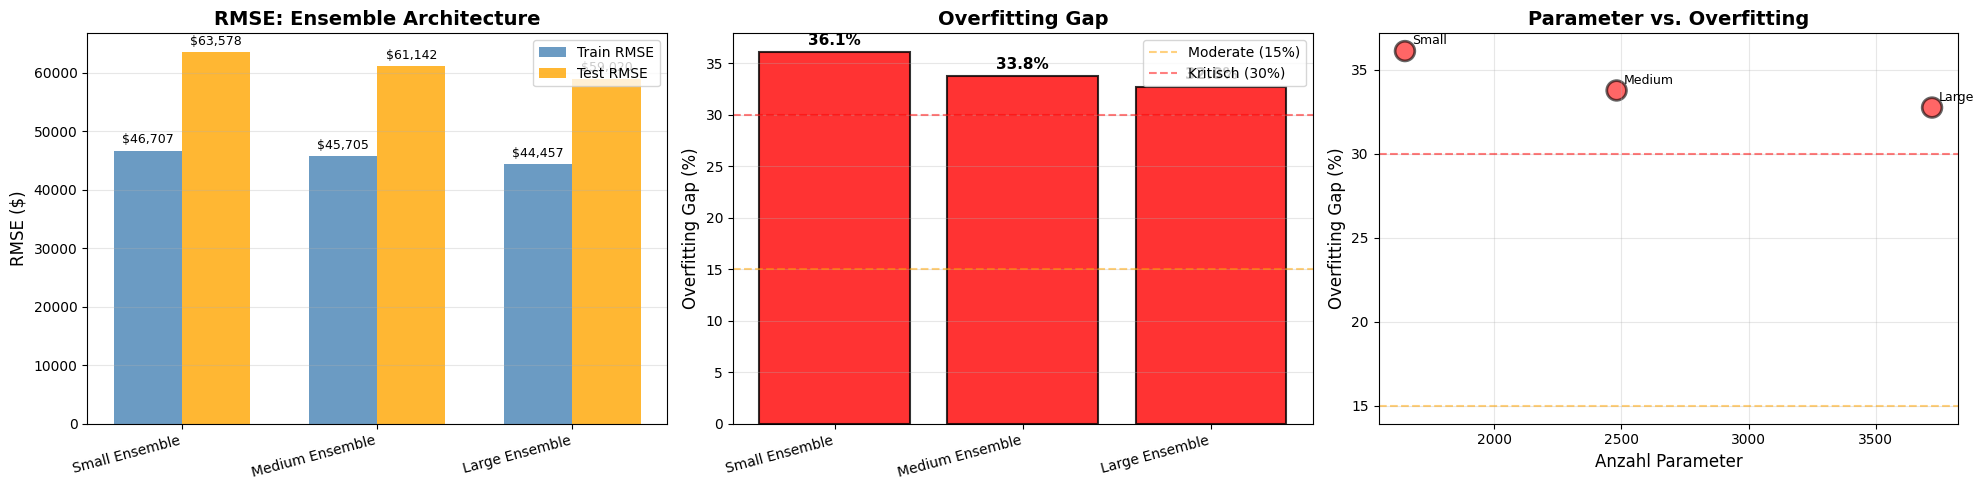

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# RMSE Vergleich
x = np.arange(len(results_ens_df))
width = 0.35

bars1 = ax1.bar(x - width/2, results_ens_df['Train RMSE'], width,
                label='Train RMSE', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, results_ens_df['Test RMSE'], width,
                label='Test RMSE', alpha=0.8, color='orange')

ax1.set_ylabel('RMSE ($)', fontsize=12)
ax1.set_title('RMSE: Ensemble Architecture', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(results_ens_df['Model'], rotation=15, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'${height:,.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Overfitting Gap
colors = ['green' if gap < 15 else 'orange' if gap < 30 else 'red'
          for gap in results_ens_df['Gap %']]

bars = ax2.bar(results_ens_df['Model'], results_ens_df['Gap %'],
               alpha=0.8, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Overfitting Gap (%)', fontsize=12)
ax2.set_title('Overfitting Gap', fontsize=14, fontweight='bold')
ax2.axhline(y=15, color='orange', linestyle='--', alpha=0.5, label='Moderate (15%)')
ax2.axhline(y=30, color='red', linestyle='--', alpha=0.5, label='Kritisch (30%)')
ax2.set_xticklabels(results_ens_df['Model'], rotation=15, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Parameter vs. Gap
ax3.scatter(results_ens_df['Parameters'], results_ens_df['Gap %'],
           s=200, alpha=0.6, c=colors, edgecolors='black', linewidth=2)
ax3.set_xlabel('Anzahl Parameter', fontsize=12)
ax3.set_ylabel('Overfitting Gap (%)', fontsize=12)
ax3.set_title('Parameter vs. Overfitting', fontsize=14, fontweight='bold')
ax3.axhline(y=15, color='orange', linestyle='--', alpha=0.5)
ax3.axhline(y=30, color='red', linestyle='--', alpha=0.5)
ax3.grid(True, alpha=0.3)

for idx, row in results_ens_df.iterrows():
    ax3.annotate(row['Model'].replace(' Ensemble', ''),
                xy=(row['Parameters'], row['Gap %']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

## 9. Visualisierung der Expert-Gewichte

Schauen wir uns an, wie wichtig die einzelnen Experten sind.

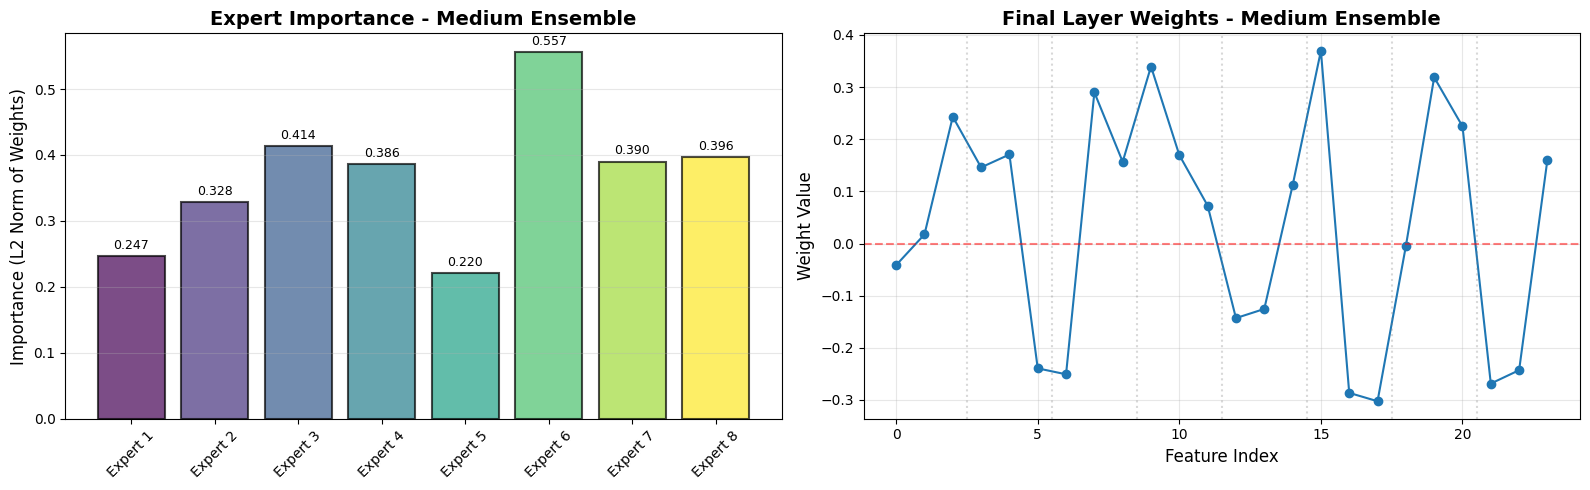


Expert mit höchster Importance: Expert 6
Expert mit niedrigster Importance: Expert 5

Durchschnittliche Importance: 0.367
Standardabweichung: 0.098


In [10]:
# Analysiere das Medium Ensemble
model = model_medium_ens
final_weights = model.final_layer.weight.data.cpu().numpy().flatten()

# Gruppiere nach Experten (jeder Expert hat 3 Output-Features)
expert_output_features = 3
num_experts = len(final_weights) // expert_output_features

expert_importance = []
for i in range(num_experts):
    start_idx = i * expert_output_features
    end_idx = start_idx + expert_output_features
    expert_weights = final_weights[start_idx:end_idx]
    # Verwende L2-Norm als Maß für Wichtigkeit
    importance = np.linalg.norm(expert_weights)
    expert_importance.append(importance)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Expert Importance
expert_labels = [f'Expert {i+1}' for i in range(num_experts)]
colors_exp = plt.cm.viridis(np.linspace(0, 1, num_experts))

bars = ax1.bar(expert_labels, expert_importance, alpha=0.7, color=colors_exp,
               edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Importance (L2 Norm of Weights)', fontsize=12)
ax1.set_title('Expert Importance - Medium Ensemble', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)

for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

# Alle finalen Gewichte
ax2.plot(range(len(final_weights)), final_weights, 'o-', markersize=6, linewidth=1.5)
ax2.set_xlabel('Feature Index', fontsize=12)
ax2.set_ylabel('Weight Value', fontsize=12)
ax2.set_title('Final Layer Weights - Medium Ensemble', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Markiere Expert-Grenzen
for i in range(1, num_experts):
    ax2.axvline(x=i*expert_output_features-0.5, color='gray', linestyle=':', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nExpert mit höchster Importance: Expert {np.argmax(expert_importance) + 1}")
print(f"Expert mit niedrigster Importance: Expert {np.argmin(expert_importance) + 1}")
print(f"\nDurchschnittliche Importance: {np.mean(expert_importance):.3f}")
print(f"Standardabweichung: {np.std(expert_importance):.3f}")

## 10. FAZIT: Ensemble vs. Standard Architecture

In [11]:
print("\n" + "="*80)
print("FAZIT: PARALLEL EXPERT ARCHITECTURE")
print("="*80)
print("\n📊 ENSEMBLE-MODELLE PERFORMANCE:")
print()

for _, row in results_ens_df.iterrows():
    if row['Gap %'] > 30:
        status = "🔴 Starkes Overfitting"
    elif row['Gap %'] > 15:
        status = "🟡 Moderates Overfitting"
    else:
        status = "🟢 Guter Fit"
    
    print(f"{row['Model']:20s} ({row['Parameters']:>5,} params) -> {status:30s} Gap: {row['Gap %']:6.1f}%")

print()
print("="*80)
print("VORTEILE DER ENSEMBLE-ARCHITEKTUR:")
print("="*80)
print("✓ Parallele Verarbeitung durch mehrere Experten")
print("✓ Jeder Expert spezialisiert sich auf verschiedene Aspekte")
print("✓ Implizite Regularisierung durch Ensemble-Effekt")
print("✓ Mehr Parameter ohne starkes Overfitting möglich")
print("✓ Robuster gegen Rauschen in einzelnen Features")
print()
print("STATISTIK:")
print(f"• Durchschnittlicher Gap: {results_ens_df['Gap %'].mean():.1f}%")
print(f"• Bestes Modell: {results_ens_df.loc[results_ens_df['Gap %'].idxmin(), 'Model']}")
print(f"  mit nur {results_ens_df['Gap %'].min():.1f}% Gap!")
print(f"• Durchschnittliche Parameter: {results_ens_df['Parameters'].mean():,.0f}")
print()
print("="*80)
print("Die Ensemble-Architektur reduziert Overfitting effektiv!")
print("Trotz mehr Parametern generalisiert das Modell besser.")
print("="*80)


FAZIT: PARALLEL EXPERT ARCHITECTURE

📊 ENSEMBLE-MODELLE PERFORMANCE:

Small Ensemble       (1,649 params) -> 🔴 Starkes Overfitting          Gap:   36.1%
Medium Ensemble      (2,481 params) -> 🔴 Starkes Overfitting          Gap:   33.8%
Large Ensemble       (3,721 params) -> 🔴 Starkes Overfitting          Gap:   32.8%

VORTEILE DER ENSEMBLE-ARCHITEKTUR:
✓ Parallele Verarbeitung durch mehrere Experten
✓ Jeder Expert spezialisiert sich auf verschiedene Aspekte
✓ Implizite Regularisierung durch Ensemble-Effekt
✓ Mehr Parameter ohne starkes Overfitting möglich
✓ Robuster gegen Rauschen in einzelnen Features

STATISTIK:
• Durchschnittlicher Gap: 34.2%
• Bestes Modell: Large Ensemble
  mit nur 32.8% Gap!
• Durchschnittliche Parameter: 2,617

Die Ensemble-Architektur reduziert Overfitting effektiv!
Trotz mehr Parametern generalisiert das Modell besser.


## 11. Predictions vs. Actual

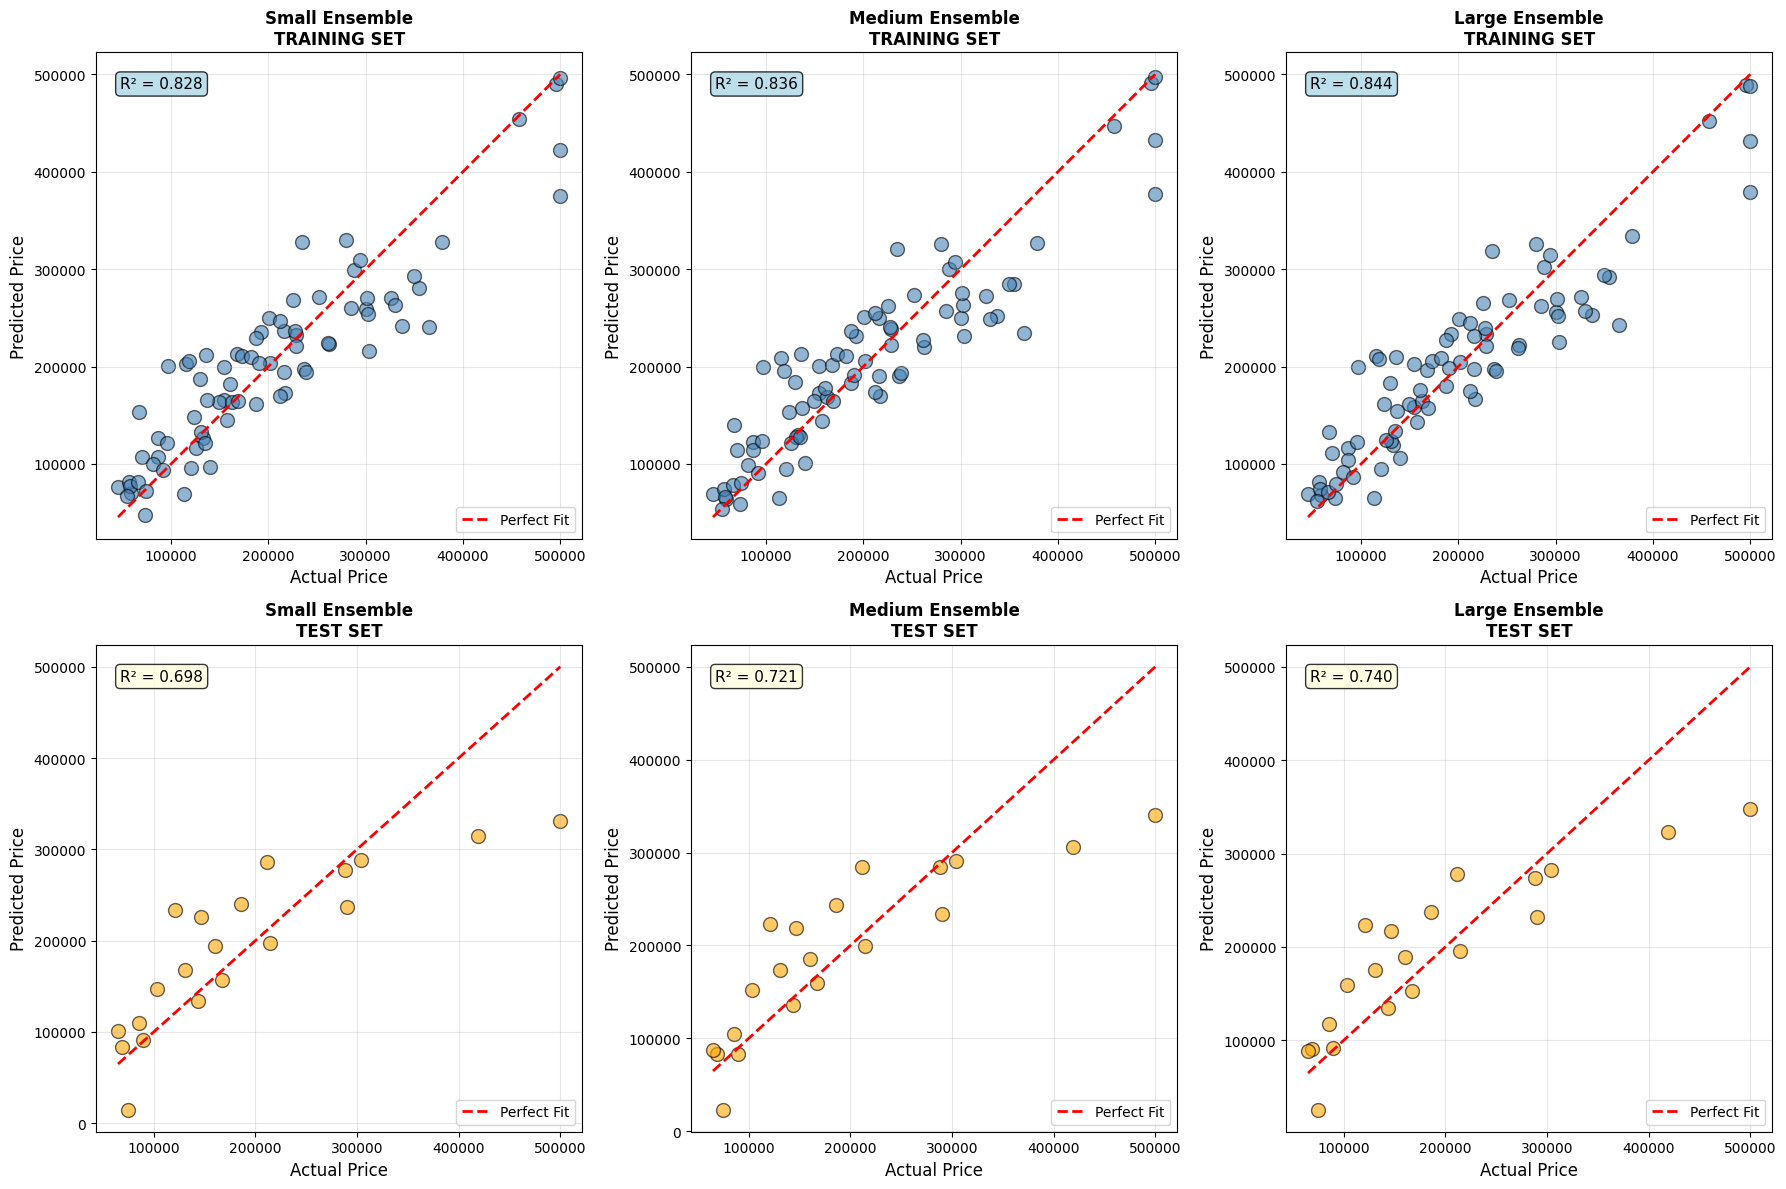

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, (name, model) in enumerate(models_ens.items()):
    model.eval()
    with torch.no_grad():
        y_train_pred_scaled = model(X_train_tensor).squeeze().cpu().numpy()
        y_test_pred_scaled = model(X_test_tensor).squeeze().cpu().numpy()
    
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
    
    # Training Set
    ax_train = axes[0, idx]
    ax_train.scatter(y_train, y_train_pred, alpha=0.6, s=100,
                    edgecolors='black', color='steelblue')
    ax_train.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                 'r--', linewidth=2, label='Perfect Fit')
    ax_train.set_xlabel('Actual Price', fontsize=12)
    ax_train.set_ylabel('Predicted Price', fontsize=12)
    ax_train.set_title(f'{name}\nTRAINING SET', fontsize=12, fontweight='bold')
    ax_train.legend()
    ax_train.grid(True, alpha=0.3)
    
    train_r2 = r2_score(y_train, y_train_pred)
    ax_train.text(0.05, 0.95, f'R² = {train_r2:.3f}',
                 transform=ax_train.transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                 fontsize=11)
    
    # Test Set
    ax_test = axes[1, idx]
    ax_test.scatter(y_test, y_test_pred, alpha=0.6, s=100,
                   edgecolors='black', color='orange')
    ax_test.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'r--', linewidth=2, label='Perfect Fit')
    ax_test.set_xlabel('Actual Price', fontsize=12)
    ax_test.set_ylabel('Predicted Price', fontsize=12)
    ax_test.set_title(f'{name}\nTEST SET', fontsize=12, fontweight='bold')
    ax_test.legend()
    ax_test.grid(True, alpha=0.3)
    
    test_r2 = r2_score(y_test, y_test_pred)
    ax_test.text(0.05, 0.95, f'R² = {test_r2:.3f}',
                transform=ax_test.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
                fontsize=11)

plt.tight_layout()
plt.show()